In [1]:
# needed for import pycytominer to work
import scipy
from scipy.stats import median_abs_deviation
scipy.stats.median_absolute_deviation = median_abs_deviation
import anndata as ad
import pandas as pd
import numpy as np
import pycytominer as pc
import scanpy as sc

# Run Pycytominer: Normalization and Feature Selection

(0. jump_imputation.ipynb: Missing value imputation, removing blocklist features and feature with too many nan values)

In this notebook:
* [1. Create Profiles](#profiles)
* [2. Normalize Features (MAD)](#normalize)
* [3. Feature Selection](#featselect)
* [4. Spherize](#spherize)

|step|# features after step|
|---|---|
|Raw Data|4762|
|Imputation|4706|
|Normalization|4706|
|Feature Selection|558|
|Spherize|558|

Read in the data (result from `notebooks/data_preprocessing/jump_imputation.ipynb`):

In [2]:
adata_target2 = ad.read_h5ad("../../data/jump/jump_target2_imputed.h5ad")
adata_target2

AnnData object with n_obs × n_vars = 64464 × 4706
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'Metadata_WellType', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Objective_NA', 'Metadata_N_Brightfield_Planes_Min', 'Metadata_N_Brightfield_Planes_Max', 'Metadata_Distance_Between_Z_Microns', 'Metadata_Sites_Per_Well', 'Metadata_Filter_Configuration', 'Metadata_Excitation_Low_DNA', 'Metadata_Excitation_Low_ER', 'Metadata_Excitation_Low_RNA', 'Metadata_Excitation_Low_AGP', 'Metadata_Excitation_Low_Mito', 'Metadata_Excitation_High_DNA', 'Metadata_Excitation_High_ER', 'Metadata_Excitation_High_RNA', 'Metadata_Excitation_High_AGP', 'Metadata_Excitation_High_Mito', 'Metadata_Emission_Low_DNA', 'Metadata_Emission_Low_ER', 'Metadata_Emission_Low_RNA', 'Metadata_Emission_Low_AGP', 'Metadata_Emission_Low_Mito', 'Metadata_Emission_High_DNA', 'Metada

drop compound metadata (contains nans)

In [3]:
adata_target2.obs.drop(columns=adata_target2.obs.columns[-8:], axis=1, inplace=True)

In [4]:
adata_target2.obs.drop(columns="Metadata_Distance_Between_Z_Microns", axis=1, inplace=True)

## 1. Create Profiles <a class="anchor" id="profiles"></a>

**Create pandas dataframe for normalization**

In [5]:
metadata = adata_target2.obs
metadata.head()

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Metadata_Emission_Low_ER,Metadata_Emission_Low_RNA,Metadata_Emission_Low_AGP,Metadata_Emission_Low_Mito,Metadata_Emission_High_DNA,Metadata_Emission_High_ER,Metadata_Emission_High_RNA,Metadata_Emission_High_AGP,Metadata_Emission_High_Mito,Metadata_FPBase_Config
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,500.0,581.5,581.5,661.5,467.5,550.0,618.5,618.5,690.5,http://broad.io/JUMPProductionConfigCV8000
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,500.0,581.5,581.5,661.5,467.5,550.0,618.5,618.5,690.5,http://broad.io/JUMPProductionConfigCV8000
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,500.0,581.5,581.5,661.5,467.5,550.0,618.5,618.5,690.5,http://broad.io/JUMPProductionConfigCV8000
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,500.0,581.5,581.5,661.5,467.5,550.0,618.5,618.5,690.5,http://broad.io/JUMPProductionConfigCV8000
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,500.0,581.5,581.5,661.5,467.5,550.0,618.5,618.5,690.5,http://broad.io/JUMPProductionConfigCV8000


In [6]:
with open("../../data/jump/target2_metadata.txt","w+") as f:
    for line in metadata.columns:
        f.write(f"{line}\n")

In [7]:
features = pd.DataFrame(adata_target2.X, columns = adata_target2.var.index)
features

,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,2972.4,6387.4,586.37,560.34,507.18,480.19,546.72,519.66,2.6556,0.82131,...,46.7820,40.8260,47.0480,48.2570,46.9350,48.1520,48.7950,50.1630,49.1250,50.1740
1,3134.5,6601.0,508.22,567.50,429.44,484.90,468.39,525.72,2.6599,0.82976,...,25.6070,23.1280,26.6730,27.1620,26.3630,27.1780,27.6340,28.0500,27.3910,28.1970
2,2995.2,6406.1,538.87,548.18,460.60,466.81,499.39,507.03,2.6466,0.83256,...,38.0640,33.3610,37.5740,38.2970,37.4180,38.3690,38.7800,39.4270,38.7050,39.5830
3,3017.5,6358.2,563.13,537.36,482.72,458.59,522.38,497.54,2.5986,0.82182,...,45.7140,40.3380,46.0870,47.0210,45.9320,47.1160,47.6800,48.5670,47.5610,48.6770
4,2995.9,6493.9,532.85,587.49,454.79,505.73,493.45,546.03,2.4955,0.81958,...,52.7130,48.5420,52.4000,53.4810,52.0620,53.2910,54.2230,55.4600,53.9870,55.3660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,3303.7,6153.5,514.84,519.03,438.32,440.31,475.96,479.07,2.3107,0.76807,...,2.3945,2.3296,2.2707,2.2821,2.2672,2.2987,2.3121,2.3585,2.3094,2.3774
64460,3376.2,6471.1,535.32,538.05,454.79,459.05,494.61,497.94,2.3174,0.78317,...,2.3402,2.1777,2.1627,2.1811,2.1544,2.1919,2.2161,2.2842,2.2124,2.2870
64461,3254.0,6156.9,529.68,528.15,452.22,450.04,490.52,488.56,2.3413,0.77440,...,2.1538,2.0642,2.0183,2.0271,2.0083,2.0304,2.0459,2.1126,2.0449,2.1013
64462,3188.8,6090.0,522.20,519.79,445.16,442.14,483.34,480.39,2.3344,0.77956,...,3.1756,2.9922,2.9419,2.9699,2.9372,2.9784,3.0106,3.1286,2.9978,3.1076


In [8]:
with open("../../data/jump/target2_feature_names.txt","w+") as f:
    for line in adata_target2.var.index:
        f.write(f"{line}\n")

In [9]:
features.index = range(64464)
metadata.index = range(64464)

In [10]:
# merge both data frames:
features = pd.merge(metadata, features, left_index = True, right_index = True)
features

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,46.7820,40.8260,47.0480,48.2570,46.9350,48.1520,48.7950,50.1630,49.1250,50.1740
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,25.6070,23.1280,26.6730,27.1620,26.3630,27.1780,27.6340,28.0500,27.3910,28.1970
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,38.0640,33.3610,37.5740,38.2970,37.4180,38.3690,38.7800,39.4270,38.7050,39.5830
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,45.7140,40.3380,46.0870,47.0210,45.9320,47.1160,47.6800,48.5670,47.5610,48.6770
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,52.7130,48.5420,52.4000,53.4810,52.0620,53.2910,54.2230,55.4600,53.9870,55.3660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004395,Y37,TARGET2,treatment,Opera Phenix,Widefield,...,2.3945,2.3296,2.2707,2.2821,2.2672,2.2987,2.3121,2.3585,2.3094,2.3774
64460,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I13,TARGET2,treatment,Opera Phenix,Widefield,...,2.3402,2.1777,2.1627,2.1811,2.1544,2.1919,2.2161,2.2842,2.2124,2.2870
64461,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I37,TARGET2,treatment,Opera Phenix,Widefield,...,2.1538,2.0642,2.0183,2.0271,2.0083,2.0304,2.0459,2.1126,2.0449,2.1013
64462,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,Y13,TARGET2,treatment,Opera Phenix,Widefield,...,3.1756,2.9922,2.9419,2.9699,2.9372,2.9784,3.0106,3.1286,2.9978,3.1076


## 2. Normalize Features <a class="anchor" id="normalize"></a>

Available normalization methods:
- "standardize"
  - uses sklearn.preprocessing StandardScaler
  - z = (x - mean) / sd
- "robustize"
  - uses sklearn.preprocessing RobustScaler
    - Scale features using statistics that are robust to outliers
    - scaled = (x - median) / IQR
    
      (IQR == Interquartile Range)
- "mad_robustize"
  - scaled = (x - median) / mad
- "spherize"
  - transforms into vectors whose covariance is the identity matrix
  - -> meaning that they are uncorrelated and each have variance 1

**Chosen method == "mad_robustize", plate-wise**

In [11]:
for plate in features["Metadata_Plate"].unique():
  features.loc[features["Metadata_Plate"] == plate] = pc.normalize(features[features["Metadata_Plate"] == plate],
                                                                   features = list(adata_target2.var.index.values),
                                                                   meta_features = list(metadata.columns),
                                                                   method = "mad_robustize",
                                                                   samples = "Metadata_WellType == 'DMSO'")

In [12]:
features.to_csv("../../data/jump/target2_profiles_normalized.csv", compression='gzip')

In [13]:
features.head()

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,-0.425339,-0.865407,-0.391177,-0.377283,-0.504986,-0.388730,-0.361701,-0.319453,-0.405932,-0.289039
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,-2.643884,-2.543497,-2.579051,-2.832310,-2.873830,-2.801176,-2.769876,-2.823216,-2.807881,-2.775110
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,41.439050,39.306349,46.651977,46.993913,47.276215,47.501270,46.508137,45.410042,47.283993,46.169697
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,-0.274125,-0.305272,-0.239266,-0.242540,-0.237972,-0.236065,-0.242079,-0.244885,-0.238958,-0.240313
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,-0.364989,-0.415351,-0.290397,-0.261996,-0.295887,-0.278167,-0.262126,-0.261278,-0.268434,-0.268839


## 3. Feature Selection <a class="anchor" id="featselect"></a>

In [4]:
metadata = pd.read_csv("../../data/jump/target2_metadata.txt", header=None)[0].tolist()
feature_names = pd.read_csv("../../data/jump/target2_feature_names.txt", header = None)[0].tolist()

In [2]:
profiles_normalized = pd.read_csv("../../data/jump/target2_profiles_normalized.csv" , compression='gzip', index_col = 0)
profiles_normalized.head()

/tmp/ipykernel_17614/2807101253.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  profiles_normalized = pd.read_csv("../../data/jump/target2_profiles_normalized.csv" , compression='gzip', index_col = 0)


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,-0.425339,-0.865407,-0.391177,-0.377283,-0.504986,-0.388730,-0.361701,-0.319453,-0.405932,-0.289039
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,-2.643884,-2.543497,-2.579051,-2.832310,-2.873830,-2.801176,-2.769876,-2.823216,-2.807881,-2.775110
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,41.439050,39.306349,46.651977,46.993913,47.276215,47.501270,46.508137,45.410042,47.283993,46.169697
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,-0.274125,-0.305272,-0.239266,-0.242540,-0.237972,-0.236065,-0.242079,-0.244885,-0.238958,-0.240313
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,-0.364989,-0.415351,-0.290397,-0.261996,-0.295887,-0.278167,-0.262126,-0.261278,-0.268434,-0.268839


In [ ]:
pc.feature_select(profiles_normalized,
                  features = feature_names,
                  operation = ["variance_threshold", "correlation_threshold","drop_outliers", "noise_removal"],
                  noise_removal_perturb_groups = "Metadata_JCP2022",
                  output_file = "../../data/jump/target2_profiles_featureselected.csv",
                  compression_options = "gzip"
)

## 4. Spherize <a class="anchor" id="spherize"></a>

In [2]:
profiles_feature_selected =  pd.read_csv("../../data/jump/target2_profiles_featureselected.csv", compression = "gzip")
profiles_feature_selected

/tmp/ipykernel_14865/1997219531.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  profiles_feature_selected =  pd.read_csv("../../data/jump/target2_profiles_featureselected.csv", compression = "gzip")


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Nuclei_Texture_DifferenceEntropy_ER_3_00_256,Nuclei_Texture_InfoMeas1_AGP_3_02_256,Nuclei_Texture_InfoMeas1_ER_10_03_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_10_01_256,Nuclei_Texture_InfoMeas1_Mito_3_00_256,Nuclei_Texture_InfoMeas1_RNA_10_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InverseDifferenceMoment_AGP_3_02_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_00_256
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,-1.454349,1.486974,0.686921,1.395335,-1.336355,-0.818182,-1.168324,-1.273930,0.476123,1.500728
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,-3.435806,2.817143,3.177128,5.691138,1.095627,2.001307,1.870224,3.188593,-0.089890,3.207259
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,8.421887,3.710115,-5.398358,15.657548,-1.101161,17.340480,-33.914162,-0.351438,-14.854629,-8.650145
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,-3.218492,-0.439701,2.467060,2.831060,2.242827,2.827517,0.079954,0.567125,-0.419679,5.230062
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,-1.842787,9.350151,1.525544,9.302106,1.233443,6.964476,-1.632982,1.610033,-1.228006,2.518973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004395,Y37,TARGET2,treatment,Opera Phenix,Widefield,...,-8.148452,10.005615,4.599676,6.518414,6.845953,9.080997,4.906863,2.897112,17.710651,9.248657
64460,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I13,TARGET2,treatment,Opera Phenix,Widefield,...,-1.056699,1.004498,0.676483,0.800819,2.666750,1.731189,0.976199,0.482433,1.903406,1.238686
64461,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I37,TARGET2,treatment,Opera Phenix,Widefield,...,-1.309569,1.011039,0.756279,0.685100,1.796454,0.692544,0.904160,0.221080,1.964591,1.597107
64462,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,Y13,TARGET2,treatment,Opera Phenix,Widefield,...,-0.924402,0.939039,0.425657,0.437020,2.321124,1.197659,0.751858,0.018886,2.018822,1.198642


In [5]:
profiles_spherized = pc.normalize(profiles_feature_selected,
                                  features = "infer",
                                  image_features = True,
                                  meta_features = metadata,
                                  method = "spherize",
                                  samples = "Metadata_WellType == 'DMSO'")

In [6]:
profiles_spherized

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType,Metadata_WellType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,Nuclei_Texture_DifferenceEntropy_ER_3_00_256,Nuclei_Texture_InfoMeas1_AGP_3_02_256,Nuclei_Texture_InfoMeas1_ER_10_03_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_10_01_256,Nuclei_Texture_InfoMeas1_Mito_3_00_256,Nuclei_Texture_InfoMeas1_RNA_10_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InverseDifferenceMoment_AGP_3_02_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_00_256
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2,treatment,CV8000,Confocal,...,-0.041065,-0.453122,0.283962,1.699580,-1.422685,-2.015169,0.266129,-1.443735,0.633692,2.816102
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2,treatment,CV8000,Confocal,...,-2.030765,0.150938,0.533671,1.082564,0.807731,1.792164,-0.159967,0.417226,1.613766,0.816768
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2,treatment,CV8000,Confocal,...,11.561752,22.349330,18.803231,-9.335688,-1.296641,-2.408308,-35.011629,0.697478,12.406059,-5.938709
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2,treatment,CV8000,Confocal,...,27.610746,7.999663,-16.230384,-8.791610,-5.379432,-2.529416,26.090454,0.268706,8.838393,-21.173537
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2,treatment,CV8000,Confocal,...,-4.659839,2.225773,-3.516421,-2.681825,0.236952,-6.405323,2.012551,-6.279639,0.849878,-0.349660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004395,Y37,TARGET2,treatment,Opera Phenix,Widefield,...,-16.497934,-0.317400,5.582439,-4.014925,-3.035130,-2.472762,-0.390777,-3.249645,13.588246,0.367255
64460,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I13,TARGET2,treatment,Opera Phenix,Widefield,...,-0.641987,-0.202596,0.116518,0.263905,0.314853,0.545725,0.375631,0.045585,0.635896,1.018486
64461,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,I37,TARGET2,treatment,Opera Phenix,Widefield,...,-0.077017,-0.615388,0.293207,0.249998,0.488629,0.417757,0.515435,-0.182656,0.142829,1.100226
64462,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,source_9,GR00004409,Y13,TARGET2,treatment,Opera Phenix,Widefield,...,0.000159,-0.482125,0.048009,0.394420,0.312112,0.396420,0.720651,0.143019,0.457793,1.343431


Make anndata out of data table and save to h5ad file

In [7]:
adata = sc.AnnData(profiles_spherized.iloc[:, 37:].to_numpy())
adata.var_names = profiles_spherized.columns[37:]
adata.obs = profiles_spherized.iloc[:, 0:37]

In [8]:
adata

AnnData object with n_obs × n_vars = 64464 × 558
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'Metadata_WellType', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Objective_NA', 'Metadata_N_Brightfield_Planes_Min', 'Metadata_N_Brightfield_Planes_Max', 'Metadata_Sites_Per_Well', 'Metadata_Filter_Configuration', 'Metadata_Excitation_Low_DNA', 'Metadata_Excitation_Low_ER', 'Metadata_Excitation_Low_RNA', 'Metadata_Excitation_Low_AGP', 'Metadata_Excitation_Low_Mito', 'Metadata_Excitation_High_DNA', 'Metadata_Excitation_High_ER', 'Metadata_Excitation_High_RNA', 'Metadata_Excitation_High_AGP', 'Metadata_Excitation_High_Mito', 'Metadata_Emission_Low_DNA', 'Metadata_Emission_Low_ER', 'Metadata_Emission_Low_RNA', 'Metadata_Emission_Low_AGP', 'Metadata_Emission_Low_Mito', 'Metadata_Emission_High_DNA', 'Metadata_Emission_High_ER', 'Metadata_Emission

In [9]:
adata.obs.Metadata_Plate = adata.obs.Metadata_Plate.astype(str)

**Join the remaining metadata**

In [10]:
compound_meta = pd.read_table("../../data/jump/JUMP-Target-2_compound_metadata.tsv")
micro_filter = pd.read_csv("../../data/jump/microscope_filter.csv")
micro_config = pd.read_csv("../../data/jump/microscope_config.csv")
micro = micro_config.merge(micro_filter, on="Metadata_Filter_Configuration")
micro.Metadata_Source = "source_" + micro.Metadata_Source.astype(str)

In [11]:
adata.obs = adata.obs.merge(micro[["Metadata_Source", "Metadata_Distance_Between_Z_Microns"]], on="Metadata_Source")

In [12]:
adata.obs = pd.merge(
    adata.obs,
    compound_meta,
    left_on="Metadata_InChIKey",
    right_on="InChIKey",
    how="left",
)

In [62]:
adata.write("../../data/jump/jump_target2_spherized.h5ad")

In [13]:
sc.pp.neighbors(adata, use_rep="X")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/umap/dist

In [16]:
sc.tl.umap(adata)

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


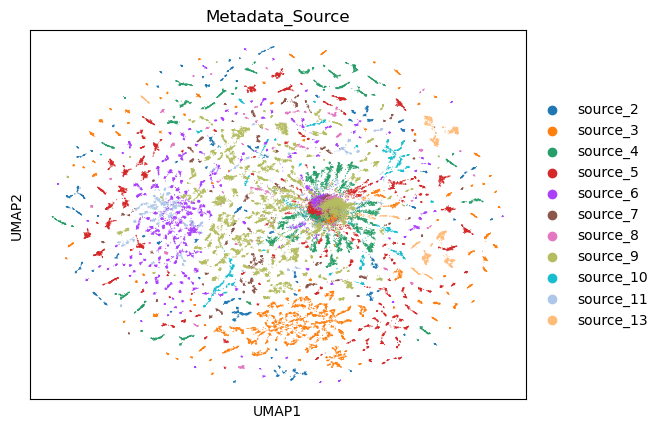

In [20]:
sc.pl.umap(adata, color="Metadata_Source")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


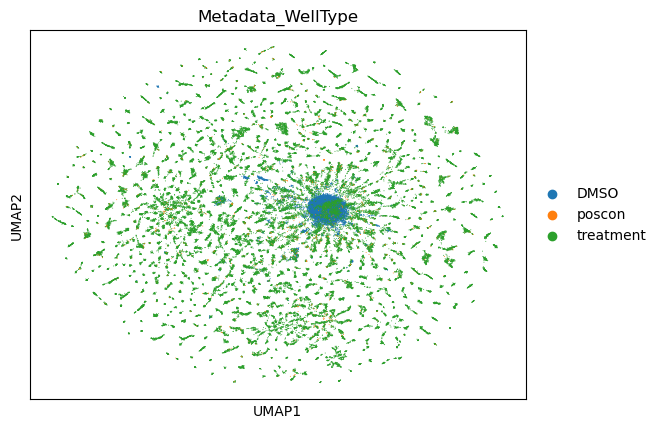

In [22]:
sc.pl.umap(adata, color="Metadata_WellType")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


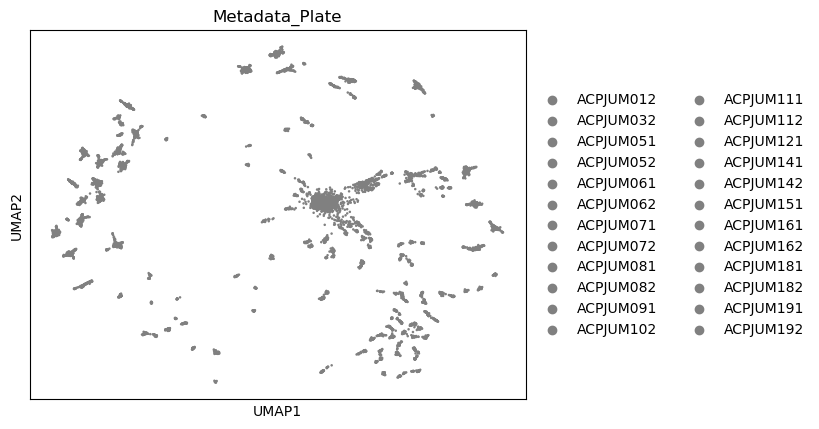

In [26]:
sc.pl.umap(adata[adata.obs.Metadata_Source=="source_5"], color="Metadata_Plate")